<a href="https://colab.research.google.com/github/jasminjahanpuspo/All_Lab_Code/blob/main/BC_Ensemble4(Inceptionv3%2BEfficientNetB3%2BB0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import cv2
import os
import pandas as pd

import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Average

In [2]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/MIAS/train'
test_directory = '/content/drive/MyDrive/MIAS/test'
valid_directory = '/content/drive/MyDrive/MIAS/val'

In [3]:
import glob as gb  # Import glob as gb

In [20]:
import os
import glob

# Specify the directory containing the .gdf5 files
directory = '/content/drive/MyDrive/MIAS/BC_Code/inceptiov3'  # Change this to your directory path

# Use glob to find all .gdf5 files in the directory
gdf5_files = glob.glob(os.path.join(directory, '*.hdf5'))

# Initialize variables to track the latest file
latest_file = None
latest_time = 0

# Iterate through the files to find the latest one
for file in gdf5_files:
    # Get the last modified time
    modified_time = os.path.getmtime(file)

    # Update latest_file if this file is newer
    if modified_time > latest_time:
        latest_time = modified_time
        latest_file = file

# Output the result
if latest_file:
    print(f"The latest .gdf5 file is: {latest_file}")
else:
    print("No .gdf5 files found.")


The latest .gdf5 file is: /content/drive/MyDrive/MIAS/BC_Code/resnet50/resnet50-24-0.8534.hdf5


In [5]:
## Define the directories for of wieghted path as .hdf5
model_1 = load_model('/content/drive/MyDrive/MIAS/BC_Code/efficientnetb0/efficientnetbo-08-0.9948.hdf5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')

model_2 = load_model('/content/drive/MyDrive/MIAS/BC_Code/oldefficientnetb3/efficientnetb3-14-0.9965.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/MIAS/BC_Code/inceptiov3/inceptionv3-27-0.9721.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

In [6]:
IMG_SIZE = (224, 224)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128       # varies from dataset to datset prefferable 128/68/32

In [7]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize parameters as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 3294 files belonging to 2 classes.
Found 573 files belonging to 2 classes.
Found 573 files belonging to 2 classes.


In [8]:
# Optional: You can also specify the class names if you have a specific order for your classes
class_names = train_dataset.class_names

# Print class names
print("Class Names:", class_names)

Class Names: ['benign', 'malignant']


In [9]:
#plot bar chart for demonstrating data size
Dataset = []
for folder in os.listdir(train_directory):
    files = gb.glob(pathname=str(train_directory + "/" + folder +"/*.*"))
    Dataset.append(len(files))

In [10]:
# Calculate total number of samples in the dataset
total = np.sum(Dataset)

# Initialize an empty dictionary to hold the weights
class_weight = {}

# Dynamically calculate the weight for each class
for i in range(len(Dataset)):
    class_weight[i] = (total / (len(Dataset) * Dataset[i]))

# Print the computed weights for each class
for class_id, weight in class_weight.items():
    print(f'Weight for class {class_id}: {weight:.2f}')

# Output the class weights dictionary
print(class_weight)

Weight for class 0: 1.00
Weight for class 1: 1.00
{0: 1.0, 1: 1.0}


In [11]:
base_learning_rate = 0.001 # prefferable lr is 0.0001 or 0.001
IMG_SHAPE = IMG_SIZE +(3,)

In [12]:
models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [13]:
## customize optimizer as Nadam or Adam
ensemble_model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
## change hyperparameter such as epoches ## EnsembleNet3: Resnet, efficientnet, densenet
history = ensemble_model.fit(train_dataset , verbose=2 , epochs=13 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True)

In [14]:
## change hyperparameter such as epoches ## EnsembleNet3: Resnet, efficientnet, densenet
history = ensemble_model.fit(train_dataset , verbose=2 , epochs=13 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True)

Epoch 1/13
26/26 - 285s - loss: 0.0299 - accuracy: 0.9967 - val_loss: 0.0421 - val_accuracy: 0.9930 - 285s/epoch - 11s/step
Epoch 2/13
26/26 - 227s - loss: 0.0502 - accuracy: 0.9933 - val_loss: 0.2857 - val_accuracy: 0.9442 - 227s/epoch - 9s/step
Epoch 3/13
26/26 - 225s - loss: 0.2241 - accuracy: 0.9806 - val_loss: 0.3000 - val_accuracy: 0.9599 - 225s/epoch - 9s/step
Epoch 4/13
26/26 - 225s - loss: 0.2685 - accuracy: 0.9678 - val_loss: 0.3949 - val_accuracy: 0.9319 - 225s/epoch - 9s/step
Epoch 5/13
26/26 - 222s - loss: 0.4589 - accuracy: 0.7838 - val_loss: 0.4423 - val_accuracy: 0.9494 - 222s/epoch - 9s/step
Epoch 6/13
26/26 - 223s - loss: 0.4069 - accuracy: 0.9484 - val_loss: 0.4281 - val_accuracy: 0.9511 - 223s/epoch - 9s/step
Epoch 7/13
26/26 - 226s - loss: 0.5854 - accuracy: 0.6612 - val_loss: 0.9000 - val_accuracy: 0.4695 - 226s/epoch - 9s/step
Epoch 8/13
26/26 - 227s - loss: 0.6711 - accuracy: 0.6785 - val_loss: 0.4807 - val_accuracy: 0.8866 - 227s/epoch - 9s/step
Epoch 9/13
26/2

In [15]:
ensemble_model.evaluate(test_dataset , verbose = 1)

5/5 [==============================] - 33s 5s/step - loss: nan - accuracy: 0.6230


[nan, 0.6230366230010986]

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = ensemble_model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = ensemble_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

2/2 [==============================] - 9s 1s/step


In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming 'model' is your trained model and 'test_dataset' is your test data
predicted_probs = []
true_labels = []
for images, labels in test_dataset:
    predictions = ensemble_model.predict(images)
    predicted_probs.extend(predictions) # Assuming your model outputs probabilities
    true_labels.extend(labels.numpy())

# Ensure predicted_probs are probabilities for the positive class
if len(predicted_probs[0]) > 1:
    predicted_probs = np.array(predicted_probs)[:, 1] # Assuming binary classification

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)

# Calculate AUC
auc = roc_auc_score(true_labels, predicted_probs)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

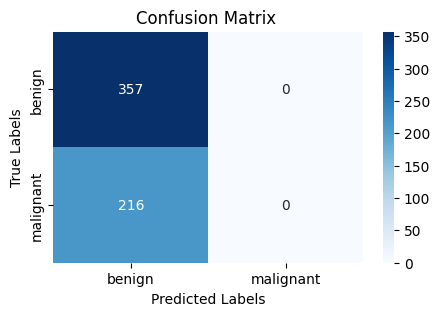

In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
## change the model name
plt.title('Confusion Matrix ')
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

In [ ]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')

In [ ]:
# Calculate total right and wrong predictions
total_right = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
total_wrong = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
total_samples = len(true_labels)

# Calculate wrong prediction percentage
wrong_prediction_percentage = (total_wrong / total_samples) * 100

print("Total Right Predictions:", total_right)
print("Total Wrong Predictions:", total_wrong)
print("Wrong Prediction Percentage: {:.2f}%".format(wrong_prediction_percentage))


# Prepare data for plotting
categories = ['Right Predictions', 'Wrong Predictions']
values = [total_right, total_wrong]

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['green', 'red'])
plt.ylabel('Count')
plt.title('Right and Wrong Predictions')

# Show counts on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

plt.show()

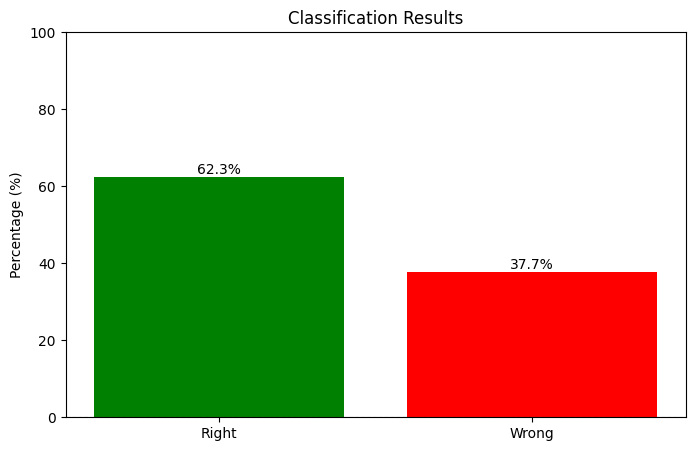

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = cm.ravel()

# Right and wrong classifications
right_classifications = TP + TN
wrong_classifications = FP + FN

# Calculate percentages
total = right_classifications + wrong_classifications
right_percentage = (right_classifications / total) * 100
wrong_percentage = (wrong_classifications / total) * 100

# Data for the bar plot
labels = ['Right', 'Wrong']
percentages = [right_percentage, wrong_percentage]


# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percentages, color=['green', 'red'])

# Add percentage labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%',
             ha='center', va='bottom')  # va: vertical alignment

# Add titles and labels
plt.title('Classification Results')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # Optional: Add a horizontal line at y=0

# Show the plot
plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Function to load a specified number of random images from subfolders
def load_random_images_from_subfolders(folder, num_images=10):
    images = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            image_files = os.listdir(subfolder_path)
            # Randomly select images from this subfolder
            selected_files = random.sample(image_files, min(num_images, len(image_files)))
            for image_file in selected_files:
                img_path = os.path.join(subfolder_path, image_file)
                img = Image.open(img_path)
                img = img.resize((64, 64))  # Resize to a consistent size if necessary
                images.append(np.array(img) / 255.0)  # Normalize pixel values
                if len(images) >= num_images:  # Stop if we have loaded enough images
                    return np.array(images)
    return np.array(images)

# Set the path to your test folder
test_folder = '/content/drive/MyDrive/MIAS/test'  # Folder containing subfolders of images

# Load a few random images from subfolders (up to 10)
images = load_random_images_from_subfolders(test_folder, num_images=5)

# Assuming you already have true and predicted labels loaded
# Replace these with your actual arrays
true_labels = true_labels  # Example true labels
predicted_labels = predicted_labels # Example predicted labels

# Set up the plot
cols = 2  # Two columns: original and predicted
rows = 10  # One row for each image

fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * 10))

# Loop through and display images
for i in range(len(images)):
    original_image = images[i]
    predicted_label = predicted_labels[i]
    true_label = true_labels[i]

    # Plot original image
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f'Original Label: {true_label}')
    axes[i, 0].axis('off')

    # Plot predicted image (optionally the same image)
    axes[i, 1].imshow(original_image, cmap='gray')
    axes[i, 1].set_title(f'Predicted Label: {predicted_label}')
    axes[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate sensitivity, specificity, and Jaccard index
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print the results
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Metrics for plotting
metrics = [sensitivity, specificity]
labels = ['Sensitivity', 'Specificity']

# Create bar plot
plt.bar(labels, metrics, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Score')
plt.title('Sensitivity and Specificity')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate Jaccard Index
jaccard_index = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

# Calculate Dice Score
dice_score = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

# Print results
print(f"Jaccard Index: {jaccard_index:.2f}")
print(f"Dice Score: {dice_score:.2f}")

# Metrics for plotting
metrics = [jaccard_index, dice_score]
labels = ['Jaccard Index', 'Dice Score']

# Create bar plot
plt.bar(labels, metrics, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score

# Example true labels and predicted labels


# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

# AUC-ROC calculation
# Ensure predicted probabilities are available if needed
# For binary classification with predicted labels as 0 and 1, we can use predicted_labels directly for AUC
# If you have probabilities instead, use that instead
# predicted_probabilities = model.predict_proba(X_test)[:, 1]  # Example for getting probabilities
# auc_roc = roc_auc_score(true_labels, predicted_probabilities)
auc_roc = roc_auc_score(true_labels, predicted_labels)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Negative Predictive Value (NPV): {npv:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")


In [ ]:
# Store metrics in a dictionary
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Negative Predictive Value (NPV)': npv,
    'AUC-ROC': auc_roc
}

# Plotting the metrics
plt.figure(figsize=(15, 5))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red', 'purple', 'cyan'])
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.axhline(y=0.5, color='grey', linestyle='--')  # Reference line at 0.5
plt.grid(axis='y')

# Show the plot
plt.show()